# Superimpose data

The aim of this notebook is to indicate how to superimpose data from different sources (radar, satellite, weather models...).

There are 2 data categories :
<ul>
    <li>data projected on a grid (radar, weather models...)</li>
    <li>punctual data like observations from ground stations</li>
</ul>

So, this notebook provides functions which allow to :
<ul>
    <li>superimpose 2 grids of different resolutions</li>
    <li>superimpose data on a grid with punctual data</li>
</ul>

# I - Superimpose 2 grids of different resolutions

## I.1 - 2 GRIB files 
### Example : 3D ARPEGE data on isobaric levels (0.1°) to interpolate to 2D AROME data on the 2m level (0.025°)
#### Use xarray to open GRIB files and perform interpolation

In [90]:
from data_exploration.utils.user_configuration import *
import xarray as xr
import datetime as dt
%matplotlib notebook
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import colors
import numpy as np

In [47]:
####Cell containing the modifiable fields######
zone = "NW"     #geographic zone (NW or SE)
arp_param = 't'    #arpege : parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
aro_param = 't2m' #arome : parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
date = dt.datetime(2018, 5, 1,0,0) # Day example 
time_step = 0                #index for the studied time step 
level_step = 0               #index for the studied level step (from ground upwards)

arp_fname = "../data_sample/weather_models/arpege_3D_isobar_%s_%s.grib" % (zone,date.strftime('%Y%m%d%H%M%S'))
aro_fname = "../data_sample/weather_models/arome_2m_%s_%s.grib" % (zone,date.strftime('%Y%m%d%H%M%S'))

In [48]:
#/!\#### the plots options depend on the GRIB file structure (for example, 'isobaricInhPa =' means we have a 3D grib file with isobaric levels)
def grib_interpolate_plot1(ori_fname,tar_fname,time_step,level_step,ori_param,tar_param):
    
    #data loading
    data_to_interpolate = xr.open_dataset(ori_fname, engine='cfgrib')  
    target_data = xr.open_dataset(tar_fname, engine='cfgrib')  
    
    #today, with the function above, 2 interpolation methods are implemented for 2D arrays : 'linear' and 'nearest' for nearest neighbors
    interpolated_data = data_to_interpolate.interp_like(target_data,method='linear')
    
    #plots
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 2, figure = fig)
    #data to interpolate
    ax =  pl.subplot(gs[0, 0])
    p1 =  data_to_interpolate.isel(step=time_step, isobaricInhPa = level_step)[ori_param].plot(x="longitude",y="latitude")
    plt.title('original data')

    #interpolated data
    ax =  pl.subplot(gs[0, 1])
    p1 = interpolated_data.isel(step=time_step, isobaricInhPa = level_step)[ori_param].plot(x="longitude",y="latitude")
    plt.title('interpolated data')

    #destination data 
    ax =  pl.subplot(gs[1, 0])
    p1 = target_data.isel(step=time_step)[tar_param].plot(x="longitude",y="latitude")
    plt.title('data on target grid')
    
    return data_to_interpolate,interpolated_data, target_data

<IPython.core.display.Javascript object>


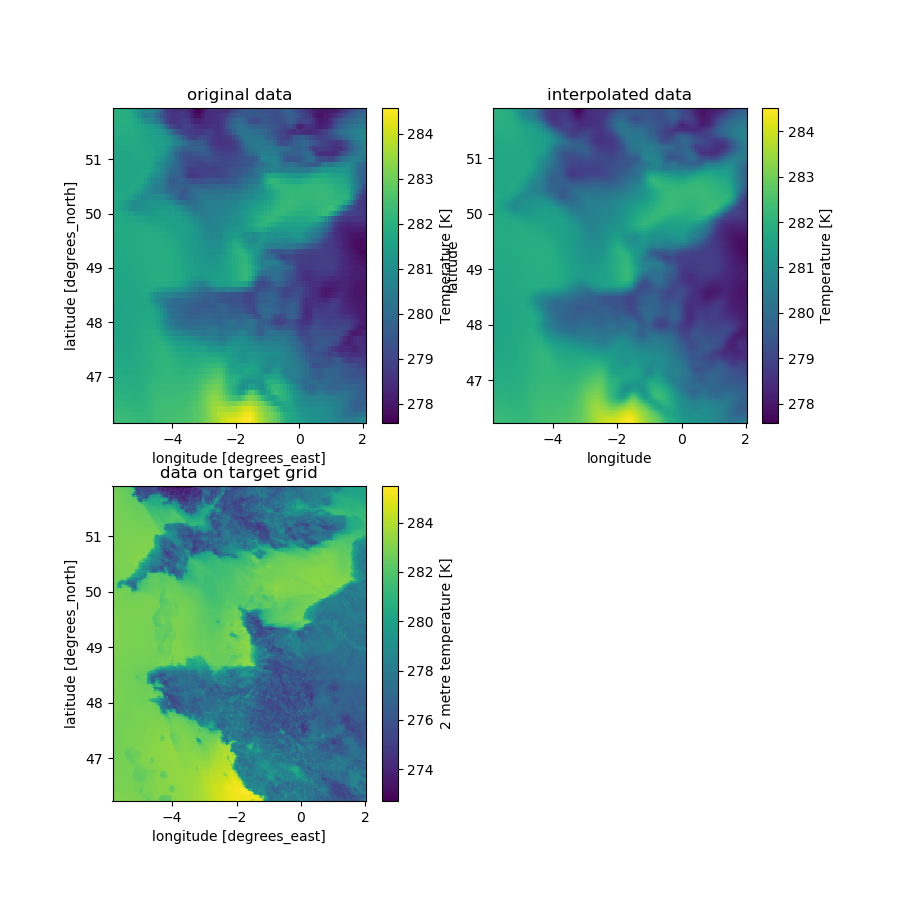

In [49]:
#data to interpolate : ARPEGE, target data : AROME
data_to_interpolate,interpolated_data, target_data = grib_interpolate_plot1(arp_fname,aro_fname,time_step,level_step,arp_param,aro_param)

## I.2 - 1 GRIB file and 1 NPZ file
### Example : rainfall data (NPZ file, 0.01°) to interpolate to land-sea mask (GRIB file, 0.025°)

In [97]:
####Cell containing the modifiable fields######
zone = "SE"
year = 2016
month = 8
decade = 3
ind = 15   #index of the chosen 5 min of the decade 

rain_param = 'rainfall'    #parameter name for rainfall
mask_param = 'lsm'         #parameter name for land-sea mask (cf meta-data in the mask GRIB file)

rain_fname = "../data_sample/radar/rainfall_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))
rain_coords_fname = "../data_sample/radar/radar_coords_%s.npz" % (zone)
mask_fname = "../data_sample/masks/%s_masks.grib" % (zone)

#### Step 1 : put NPZ data into an xarray (values, lat, lon)

In [98]:
def npz_to_grib(rain_fname,rain_coords_fname,ind):
    
    #load data
    d = np.load(rain_fname, allow_pickle=True)
    data = d['data'][ind,:,:]
    
    coords = np.load(rain_coords_fname, allow_pickle=True)
    lat = coords['lats']
    lon = coords['lons']
    
    data = xr.DataArray(data,coords=[lat[:,0],lon[0,:]],dims=['latitude','longitude'])
    d_grib = data.to_dataset(name = 'rainfall')
    
    return d_grib,lat,lon

In [99]:
d_grib,lat,lon = npz_to_grib(rain_fname,rain_coords_fname,ind)

In [115]:
np.unique(d_grib['rainfall'].values)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  77,  78,
        79,  80,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,
        94,  95,  97,  98, 101, 103, 106, 107, 108, 109, 110, 111, 112,
       115, 116, 118, 122, 123, 124, 125, 129, 133, 136, 137, 138, 139,
       142, 144, 145, 152, 153, 154, 157, 160, 162, 163, 164, 168, 169,
       171, 172, 174, 178, 181, 184, 187, 191, 196, 200, 202], dtype=int16)

#### Step 2 : perform the interpolation
**/!\ if the 'missing data' value is not nan (for example it is -1 for rainfall), it is necessary to convert these values before into nan if you want to use the linear interpolation method, else use the nearest neighbors method**

In [111]:
#/!\#### the plots options depend on the GRIB file structure###
def grib_interpolate_plot2(ori_data,tar_fname,ori_param,tar_param):
    
    #data loading
    data_to_interpolate = ori_data
    nan_data_to_interpolate = data_to_interpolate.where(data_to_interpolate["rainfall"]>-1)  #replace -1 by nan values
    target_data = xr.open_dataset(tar_fname, engine='cfgrib')  
    
    #today, with the function above, 2 interpolation methods are implemented for 2D arrays : 'linear' and 'nearest' for nearest neighbors
    interpolated_data = nan_data_to_interpolate.interp_like(target_data,method='linear')
    
    #plots
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 2, figure = fig)
        
    #colorbar definition for rainfall
    if (np.max(data_to_interpolate[ori_param].values) > 65):
        borne_max = np.max(data_to_interpolate[ori_param].values)
    else:
        borne_max = 65 + 10
    cmap = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                                  ,'cyan','lime','yellow','khaki','burlywood','orange','brown','pink','red','plum'])
    bounds = [-1,0,2,4,6,8,10,15,20,25,30,35,40,45,50,55,60,65,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    #data to interpolate without nan (original data)
    ax =  pl.subplot(gs[0, 0])    
    data_to_interpolate[ori_param].plot(cmap=cmap, norm=norm) 
    plt.title('original data - missing data  : -1')
    
    #data to interpolate with nan
    ax =  pl.subplot(gs[0, 1])    
    nan_data_to_interpolate[ori_param].plot(cmap=cmap, norm=norm) 
    plt.title('original data with nan - missing data : nan')

    #interpolated data
    ax =  pl.subplot(gs[1, 0])
    interpolated_data[ori_param].plot(cmap=cmap, norm=norm) 
    plt.title('interpolated data - missing data : nan')

    #destination data 
    ax =  pl.subplot(gs[1, 1]) 
    target_data[tar_param].plot()
    plt.title('data on target grid')
    
    return data_to_interpolate,nan_data_to_interpolate,interpolated_data, target_data

<IPython.core.display.Javascript object>


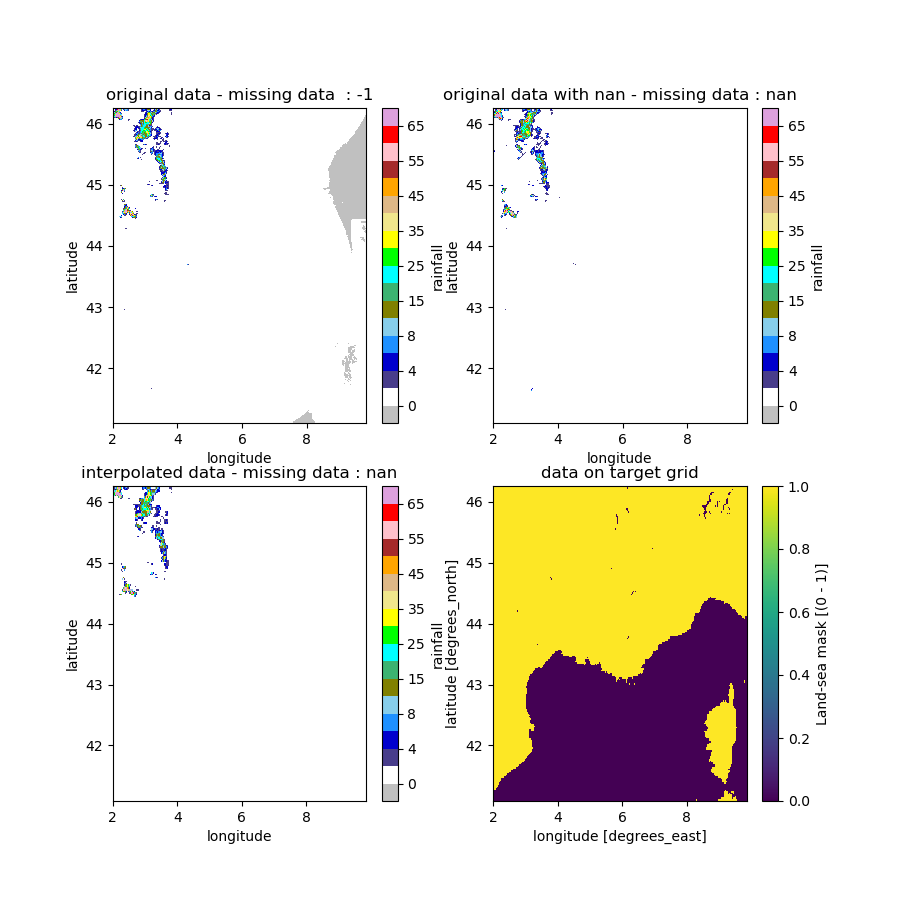

In [110]:
data_to_interpolate,nan_data_to_interpolate,interpolated_data, target_data = grib_interpolate_plot2(d_grib,mask_fname,rain_param,mask_param)

In [112]:
interpolated_data['rainfall'].values.shape

(207, 315)

In [114]:
target_data['lsm'].shape

(207, 315)

In [70]:
np.unique(interpolated_data['rainfall'].values)

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12.,
       13., 15., 16., 17., 19., 21., 22., 23., 27., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [63]:
masks

<xarray.Dataset>
Dimensions:    (latitude: 207, longitude: 315)
Coordinates:
    step       timedelta64[ns] ...
    surface    int32 ...
  * latitude   (latitude) float64 46.25 46.23 46.2 46.18 ... 41.15 41.13 41.1
  * longitude  (longitude) float64 2.0 2.025 2.05 2.075 ... 9.775 9.8 9.825 9.85
Data variables:
    lsm        (latitude, longitude) float32 ...
    p3008      (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2019-11-07T09:46:24 GRIB to CDM+CF via cfgrib-0....

<IPython.core.display.Javascript object>


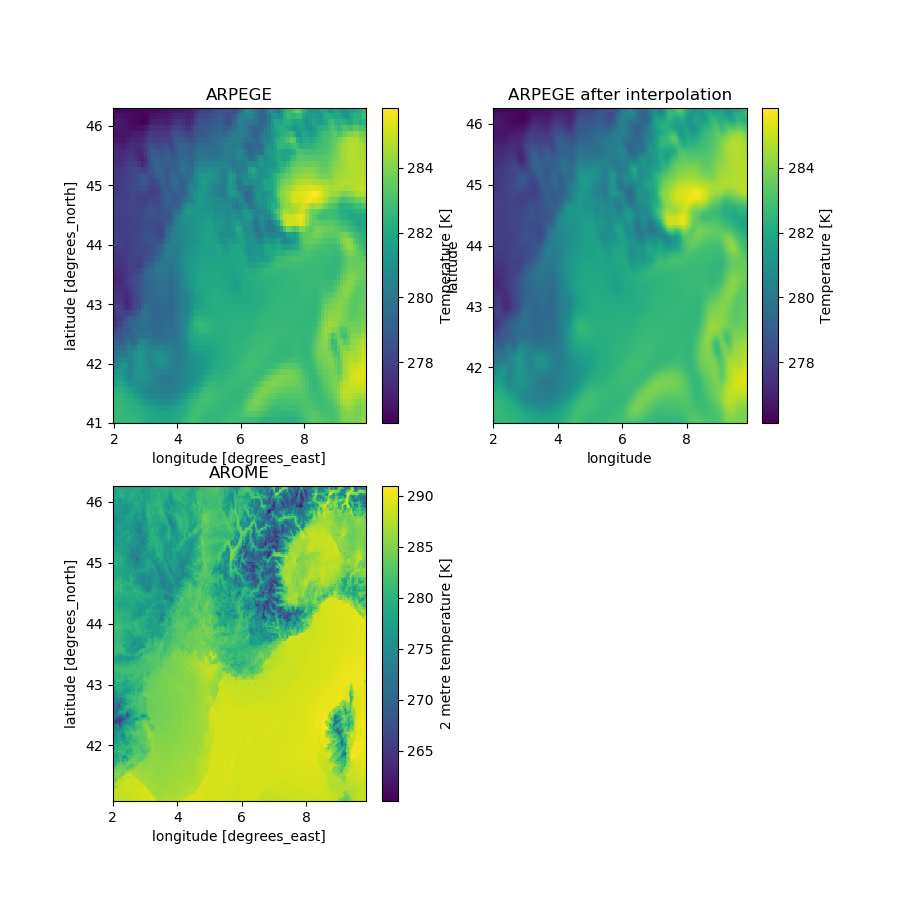

Text(0.5, 1.0, 'AROME')

In [41]:
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(2, 2, figure = fig)
#fig.suptitle(title, fontsize=12)
#ARPEGE
ax =  pl.subplot(gs[0, 0])
p1 = darp.isel(step=time_step, isobaricInhPa = level_step)[arp_param].plot(x="longitude",y="latitude")
plt.title('ARPEGE')

#ARPEGE after interpolation
ax =  pl.subplot(gs[0, 1])
p1 = darp_inter.isel(step=time_step, isobaricInhPa = level_step)[arp_param].plot(x="longitude",y="latitude")
plt.title('ARPEGE interpolated on AROME grid')

#AROME 
ax =  pl.subplot(gs[1, 0])
p1 = daro.isel(step=time_step)[aro_param].plot(x="longitude",y="latitude")
plt.title('AROME')

In [45]:
darp.interp_like?